<a href="https://colab.research.google.com/github/ravi-annaswamy/AdversarialAudioSeparation/blob/master/BIMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook reproduces the results in Section 3.1 Symbolic Formulas of the BIMT (Brain-inspired Modular Training) paper: https://arxiv.org/abs/2305.08746

## Define Brain-inspired Linear layer and MLP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle



seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None
        
    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output
    
    
class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))
                
            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 5 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    def plot(self):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                    
        ax.axis('off')
        
        
    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num
                
    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value
                
    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)
                



## The independence example. NN takes in $(x_1,x_2,x_3,x_4)$ and aims to predict $((x_1+x_3)^3, x_2^2+{\rm sin}(\pi x_4))$.


step = 0 | total loss: 1.28e+00 | train loss: 1.25e+00 | test loss 1.80e+00 | reg: 3.02e+01 


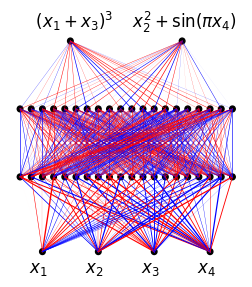

step = 200 | total loss: 2.90e-01 | train loss: 2.58e-01 | test loss 6.07e-01 | reg: 3.29e+01 
step = 400 | total loss: 1.48e-01 | train loss: 1.15e-01 | test loss 3.10e-01 | reg: 3.27e+01 
step = 600 | total loss: 7.60e-02 | train loss: 4.39e-02 | test loss 1.29e-01 | reg: 3.21e+01 
step = 800 | total loss: 4.36e-02 | train loss: 1.36e-02 | test loss 5.83e-02 | reg: 3.00e+01 
step = 1000 | total loss: 3.33e-02 | train loss: 7.02e-03 | test loss 3.42e-02 | reg: 2.63e+01 


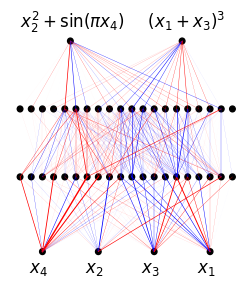

step = 1200 | total loss: 2.78e-02 | train loss: 4.54e-03 | test loss 2.61e-02 | reg: 2.32e+01 
step = 1400 | total loss: 2.39e-02 | train loss: 3.16e-03 | test loss 2.03e-02 | reg: 2.07e+01 
step = 1600 | total loss: 2.11e-02 | train loss: 2.40e-03 | test loss 1.63e-02 | reg: 1.87e+01 
step = 1800 | total loss: 1.86e-02 | train loss: 1.86e-03 | test loss 1.37e-02 | reg: 1.67e+01 
step = 2000 | total loss: 1.63e-02 | train loss: 1.40e-03 | test loss 1.20e-02 | reg: 1.49e+01 


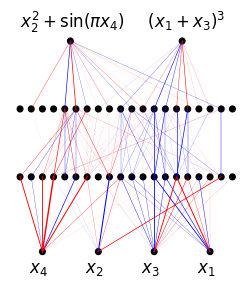

step = 2200 | total loss: 1.41e-02 | train loss: 1.01e-03 | test loss 1.08e-02 | reg: 1.31e+01 
step = 2400 | total loss: 1.27e-02 | train loss: 8.48e-04 | test loss 1.06e-02 | reg: 1.19e+01 
step = 2600 | total loss: 1.17e-02 | train loss: 7.01e-04 | test loss 1.06e-02 | reg: 1.10e+01 
step = 2800 | total loss: 1.08e-02 | train loss: 6.02e-04 | test loss 1.06e-02 | reg: 1.02e+01 
step = 3000 | total loss: 1.03e-02 | train loss: 5.52e-04 | test loss 1.09e-02 | reg: 9.73e+00 


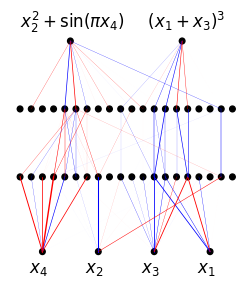

step = 3200 | total loss: 9.88e-03 | train loss: 5.12e-04 | test loss 1.09e-02 | reg: 9.36e+00 
step = 3400 | total loss: 9.51e-03 | train loss: 4.91e-04 | test loss 1.08e-02 | reg: 9.02e+00 
step = 3600 | total loss: 9.13e-03 | train loss: 4.78e-04 | test loss 1.07e-02 | reg: 8.65e+00 
step = 3800 | total loss: 8.79e-03 | train loss: 4.67e-04 | test loss 1.06e-02 | reg: 8.32e+00 
step = 4000 | total loss: 8.44e-03 | train loss: 4.61e-04 | test loss 1.08e-02 | reg: 7.98e+00 


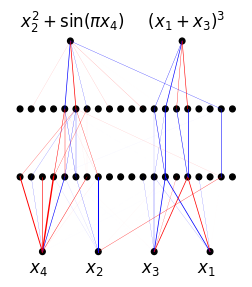

step = 4200 | total loss: 8.10e-03 | train loss: 4.54e-04 | test loss 1.10e-02 | reg: 7.64e+00 
step = 4400 | total loss: 7.80e-03 | train loss: 4.42e-04 | test loss 1.11e-02 | reg: 7.35e+00 
step = 4600 | total loss: 7.49e-03 | train loss: 4.33e-04 | test loss 1.13e-02 | reg: 7.05e+00 
step = 4800 | total loss: 7.20e-03 | train loss: 4.26e-04 | test loss 1.14e-02 | reg: 6.78e+00 
step = 5000 | total loss: 6.60e-02 | train loss: 4.25e-04 | test loss 1.17e-02 | reg: 6.56e+00 


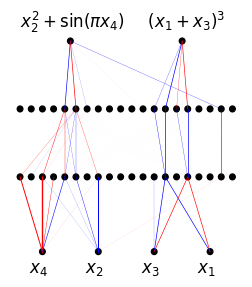

step = 5200 | total loss: 5.45e-02 | train loss: 1.81e-03 | test loss 1.72e-02 | reg: 5.27e+00 
step = 5400 | total loss: 5.02e-02 | train loss: 2.06e-03 | test loss 1.81e-02 | reg: 4.82e+00 
step = 5600 | total loss: 4.78e-02 | train loss: 2.20e-03 | test loss 1.88e-02 | reg: 4.56e+00 
step = 5800 | total loss: 4.60e-02 | train loss: 2.34e-03 | test loss 1.91e-02 | reg: 4.37e+00 
step = 6000 | total loss: 4.50e-02 | train loss: 2.45e-03 | test loss 1.92e-02 | reg: 4.25e+00 


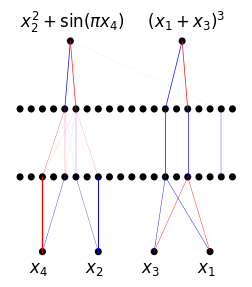

step = 6200 | total loss: 4.41e-02 | train loss: 2.55e-03 | test loss 1.91e-02 | reg: 4.15e+00 
step = 6400 | total loss: 4.34e-02 | train loss: 2.46e-03 | test loss 1.90e-02 | reg: 4.09e+00 
step = 6600 | total loss: 4.28e-02 | train loss: 2.32e-03 | test loss 1.91e-02 | reg: 4.05e+00 
step = 6800 | total loss: 4.23e-02 | train loss: 2.22e-03 | test loss 1.91e-02 | reg: 4.01e+00 
step = 7000 | total loss: 4.19e-02 | train loss: 2.07e-03 | test loss 1.92e-02 | reg: 3.98e+00 


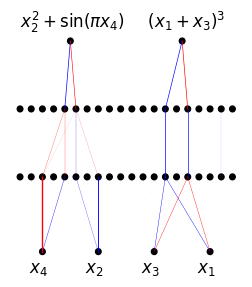

step = 7200 | total loss: 4.14e-02 | train loss: 1.97e-03 | test loss 1.93e-02 | reg: 3.95e+00 
step = 7400 | total loss: 4.13e-02 | train loss: 1.89e-03 | test loss 1.93e-02 | reg: 3.94e+00 
step = 7600 | total loss: 4.12e-02 | train loss: 1.81e-03 | test loss 1.92e-02 | reg: 3.94e+00 
step = 7800 | total loss: 4.11e-02 | train loss: 1.76e-03 | test loss 1.91e-02 | reg: 3.93e+00 
step = 8000 | total loss: 4.10e-02 | train loss: 1.74e-03 | test loss 1.92e-02 | reg: 3.93e+00 


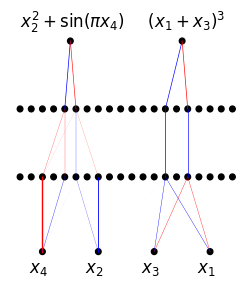

step = 8200 | total loss: 4.10e-02 | train loss: 1.69e-03 | test loss 1.91e-02 | reg: 3.93e+00 
step = 8400 | total loss: 4.09e-02 | train loss: 1.67e-03 | test loss 1.91e-02 | reg: 3.92e+00 
step = 8600 | total loss: 4.09e-02 | train loss: 1.65e-03 | test loss 1.95e-02 | reg: 3.92e+00 
step = 8800 | total loss: 4.08e-02 | train loss: 1.63e-03 | test loss 1.99e-02 | reg: 3.91e+00 
step = 9000 | total loss: 4.06e-02 | train loss: 1.64e-03 | test loss 1.96e-02 | reg: 3.90e+00 


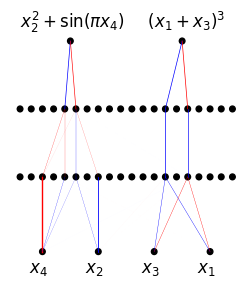

step = 9200 | total loss: 4.03e-02 | train loss: 1.67e-03 | test loss 1.94e-02 | reg: 3.87e+00 
step = 9400 | total loss: 3.95e-02 | train loss: 1.69e-03 | test loss 1.96e-02 | reg: 3.78e+00 
step = 9600 | total loss: 3.89e-02 | train loss: 1.58e-03 | test loss 1.93e-02 | reg: 3.73e+00 
step = 9800 | total loss: 3.87e-02 | train loss: 1.55e-03 | test loss 1.95e-02 | reg: 3.72e+00 
step = 10000 | total loss: 3.87e-02 | train loss: 1.54e-03 | test loss 1.92e-02 | reg: 3.71e+00 


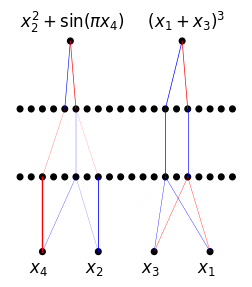

step = 10200 | total loss: 3.86e-02 | train loss: 1.51e-03 | test loss 1.93e-02 | reg: 3.71e+00 
step = 10400 | total loss: 3.85e-02 | train loss: 1.51e-03 | test loss 1.94e-02 | reg: 3.70e+00 
step = 10600 | total loss: 3.85e-02 | train loss: 1.50e-03 | test loss 1.95e-02 | reg: 3.70e+00 
step = 10800 | total loss: 3.84e-02 | train loss: 1.46e-03 | test loss 1.92e-02 | reg: 3.69e+00 
step = 11000 | total loss: 3.84e-02 | train loss: 1.44e-03 | test loss 1.91e-02 | reg: 3.70e+00 


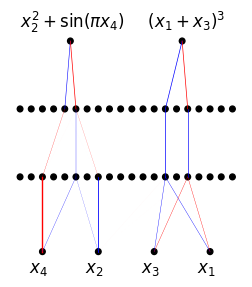

step = 11200 | total loss: 3.84e-02 | train loss: 1.41e-03 | test loss 1.93e-02 | reg: 3.70e+00 
step = 11400 | total loss: 3.83e-02 | train loss: 1.42e-03 | test loss 1.90e-02 | reg: 3.69e+00 
step = 11600 | total loss: 3.83e-02 | train loss: 1.37e-03 | test loss 1.93e-02 | reg: 3.69e+00 
step = 11800 | total loss: 3.83e-02 | train loss: 1.36e-03 | test loss 1.93e-02 | reg: 3.69e+00 
step = 12000 | total loss: 3.82e-02 | train loss: 1.36e-03 | test loss 1.92e-02 | reg: 3.69e+00 


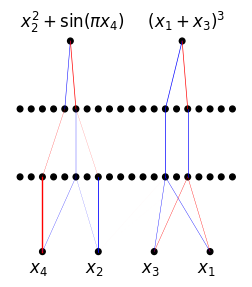

step = 12200 | total loss: 3.82e-02 | train loss: 1.37e-03 | test loss 1.89e-02 | reg: 3.68e+00 
step = 12400 | total loss: 3.82e-02 | train loss: 1.34e-03 | test loss 1.93e-02 | reg: 3.69e+00 
step = 12600 | total loss: 3.81e-02 | train loss: 1.33e-03 | test loss 1.90e-02 | reg: 3.68e+00 
step = 12800 | total loss: 3.82e-02 | train loss: 1.31e-03 | test loss 1.90e-02 | reg: 3.69e+00 
step = 13000 | total loss: 3.81e-02 | train loss: 1.31e-03 | test loss 1.91e-02 | reg: 3.68e+00 


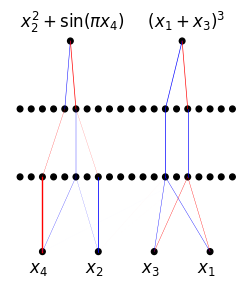

step = 13200 | total loss: 3.81e-02 | train loss: 1.29e-03 | test loss 1.90e-02 | reg: 3.68e+00 
step = 13400 | total loss: 3.81e-02 | train loss: 1.30e-03 | test loss 1.91e-02 | reg: 3.68e+00 
step = 13600 | total loss: 3.81e-02 | train loss: 1.28e-03 | test loss 1.92e-02 | reg: 3.68e+00 
step = 13800 | total loss: 3.81e-02 | train loss: 1.26e-03 | test loss 1.93e-02 | reg: 3.69e+00 
step = 14000 | total loss: 3.81e-02 | train loss: 1.26e-03 | test loss 1.90e-02 | reg: 3.68e+00 


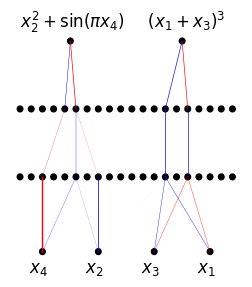

step = 14200 | total loss: 3.81e-02 | train loss: 1.25e-03 | test loss 1.92e-02 | reg: 3.68e+00 
step = 14400 | total loss: 3.81e-02 | train loss: 1.27e-03 | test loss 1.92e-02 | reg: 3.68e+00 
step = 14600 | total loss: 3.80e-02 | train loss: 1.26e-03 | test loss 1.88e-02 | reg: 3.68e+00 
step = 14800 | total loss: 3.81e-02 | train loss: 1.25e-03 | test loss 1.91e-02 | reg: 3.68e+00 
step = 15000 | total loss: 7.65e-03 | train loss: 1.25e-03 | test loss 1.87e-02 | reg: 6.40e+00 


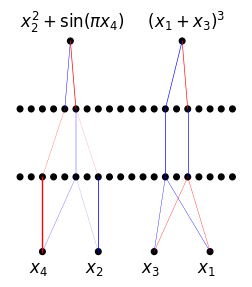

step = 15200 | total loss: 5.82e-03 | train loss: 5.24e-04 | test loss 1.32e-02 | reg: 5.30e+00 
step = 15400 | total loss: 5.59e-03 | train loss: 3.51e-04 | test loss 1.03e-02 | reg: 5.24e+00 
step = 15600 | total loss: 5.50e-03 | train loss: 2.75e-04 | test loss 8.66e-03 | reg: 5.22e+00 
step = 15800 | total loss: 5.47e-03 | train loss: 2.37e-04 | test loss 7.77e-03 | reg: 5.23e+00 
step = 16000 | total loss: 5.45e-03 | train loss: 2.16e-04 | test loss 7.23e-03 | reg: 5.24e+00 


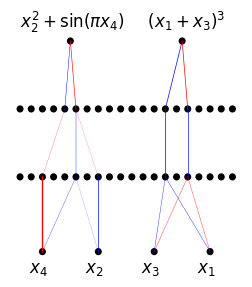

step = 16200 | total loss: 5.44e-03 | train loss: 2.03e-04 | test loss 6.98e-03 | reg: 5.24e+00 
step = 16400 | total loss: 5.44e-03 | train loss: 1.98e-04 | test loss 6.87e-03 | reg: 5.24e+00 
step = 16600 | total loss: 5.43e-03 | train loss: 1.92e-04 | test loss 6.93e-03 | reg: 5.24e+00 
step = 16800 | total loss: 5.43e-03 | train loss: 1.90e-04 | test loss 6.88e-03 | reg: 5.24e+00 
step = 17000 | total loss: 5.42e-03 | train loss: 1.89e-04 | test loss 6.92e-03 | reg: 5.24e+00 


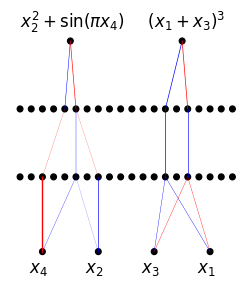

step = 17200 | total loss: 5.43e-03 | train loss: 1.96e-04 | test loss 6.98e-03 | reg: 5.23e+00 
step = 17400 | total loss: 5.42e-03 | train loss: 1.92e-04 | test loss 7.09e-03 | reg: 5.23e+00 
step = 17600 | total loss: 5.43e-03 | train loss: 2.00e-04 | test loss 7.10e-03 | reg: 5.23e+00 
step = 17800 | total loss: 5.42e-03 | train loss: 1.94e-04 | test loss 7.14e-03 | reg: 5.22e+00 
step = 18000 | total loss: 5.41e-03 | train loss: 1.92e-04 | test loss 7.24e-03 | reg: 5.22e+00 


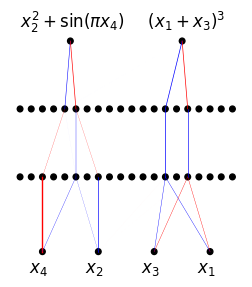

step = 18200 | total loss: 5.41e-03 | train loss: 1.96e-04 | test loss 7.23e-03 | reg: 5.22e+00 
step = 18400 | total loss: 5.42e-03 | train loss: 2.05e-04 | test loss 7.33e-03 | reg: 5.22e+00 
step = 18600 | total loss: 5.41e-03 | train loss: 1.93e-04 | test loss 7.29e-03 | reg: 5.22e+00 
step = 18800 | total loss: 5.41e-03 | train loss: 1.94e-04 | test loss 7.35e-03 | reg: 5.22e+00 
step = 19000 | total loss: 5.41e-03 | train loss: 1.96e-04 | test loss 7.33e-03 | reg: 5.21e+00 


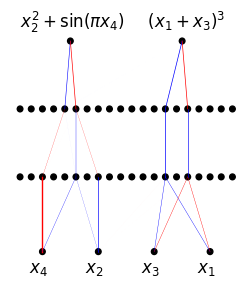

step = 19200 | total loss: 5.41e-03 | train loss: 1.95e-04 | test loss 7.39e-03 | reg: 5.21e+00 
step = 19400 | total loss: 5.41e-03 | train loss: 1.98e-04 | test loss 7.31e-03 | reg: 5.21e+00 
step = 19600 | total loss: 5.42e-03 | train loss: 2.09e-04 | test loss 7.29e-03 | reg: 5.21e+00 
step = 19800 | total loss: 5.41e-03 | train loss: 1.98e-04 | test loss 7.33e-03 | reg: 5.21e+00 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# create dataset

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)


def f(data):
    x1 = data[:,[0]]
    x2 = data[:,[1]]
    x3 = data[:,[2]]
    x4 = data[:,[3]]
    out = np.transpose(np.array([(x1+x3)**3, x2**2+np.sin(np.pi*x4)]))
    return out


d_in = 4
d_out = 2

inputs = np.random.rand(100,d_in)*2-1
labels = f(inputs)

inputs = torch.tensor(inputs, dtype=torch.float, requires_grad=True)
labels = torch.tensor(labels, dtype=torch.float, requires_grad=True)

inputs_test = np.random.rand(100,d_in)*2-1
labels_test = f(inputs_test)

inputs_test = torch.tensor(inputs_test, dtype=torch.float, requires_grad=True)
labels_test = torch.tensor(labels_test, dtype=torch.float, requires_grad=True)


width = 20
depth = 3
shp = [d_in, 20, 20, d_out]


model = BioMLP(shp=shp)

# train_type = 1; no L1
# train_type = 2; L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
train_type = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
log = 200
lamb = 0 if train_type==1 else 0.001
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.
plot_log = 1000
steps = 20000
 
for step in range(steps):
    
    if step == int(steps/4):
        lamb *= 10
    
    if step == int(3*steps/4):
        lamb *= 0.1
    
    optimizer.zero_grad()
    pred  = model(inputs)
    loss = torch.mean((pred-labels)**2)
    pred_test  = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    
    # do not penalize bias at first (this makes the weight graph look better)
    if step < int(3*steps/4):
        reg = model.get_cc(bias_penalize=False, weight_factor=weight_factor)
    else:
        reg = model.get_cc(bias_penalize=True, weight_factor=weight_factor)
    #reg = model.get_cc(bias_penalize=True)
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        model.relocate()

    if step % plot_log == 0:
        model.plot()
        formulas = [r"   $(x_1+x_3)^3$", r"$x_2^2+{\rm sin}(\pi x_4)$"]
        fontsize = 12
        for j in range(shp[0]):
            plt.text(1/(2*shp[1])+5*j/shp[1]+0.04, -0.04, "$x_{}$".format(model.in_perm[j].long()+1), fontsize=fontsize)

        for j in range(shp[-1]):
            plt.text(1/(2*shp[0])+2*j/shp[0]-0.1, 0.1*(len(shp)-1)+0.02, formulas[model.out_perm[j].long()], fontsize=fontsize)

        #plt.title("(a) independence", y=1.1,fontsize=fontsize)
        #plt.savefig("./video_figs/sf_id/{0:05d}.png".format(step))
        plt.show()
    

Text(0.5, 1.0, 'independence\n test MSE = 7.4e-3')

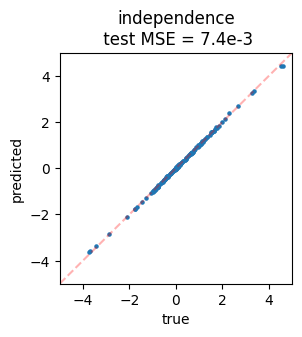

In [ ]:
plt.figure(figsize=(3,3))
plt.plot([-6,6],[-6,6],ls="--",color="red", alpha=0.3)
plt.scatter(labels_test.detach().numpy(), pred_test.detach().numpy(), s=5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("independence\n test MSE = 7.4e-3")
#plt.savefig("./fig/independence_compare.png", bbox_inches="tight")

## The feature sharing example. NN takes in $(x_1,x_2,x_3)$ and aims to predict $(x_1^2,x_1^2+x_2^2,x_1^2+x_2^2+x_3^2)$.


step = 0 | total loss: 7.82e-01 | train loss: 7.52e-01 | test loss 8.72e-01 | reg: 2.98e+01 


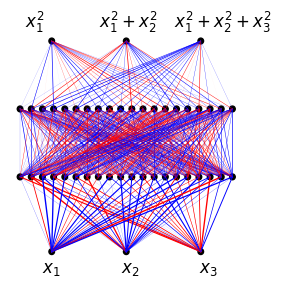

step = 200 | total loss: 1.28e-01 | train loss: 1.05e-01 | test loss 1.34e-01 | reg: 2.32e+01 
step = 400 | total loss: 4.60e-02 | train loss: 2.24e-02 | test loss 2.63e-02 | reg: 2.36e+01 
step = 600 | total loss: 2.95e-02 | train loss: 7.66e-03 | test loss 1.04e-02 | reg: 2.19e+01 
step = 800 | total loss: 1.99e-02 | train loss: 1.02e-03 | test loss 1.75e-03 | reg: 1.89e+01 
step = 1000 | total loss: 1.65e-02 | train loss: 6.78e-04 | test loss 1.37e-03 | reg: 1.58e+01 


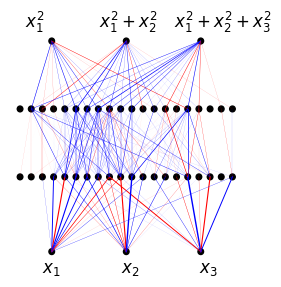

step = 1200 | total loss: 1.40e-02 | train loss: 5.06e-04 | test loss 1.13e-03 | reg: 1.35e+01 
step = 1400 | total loss: 1.22e-02 | train loss: 3.98e-04 | test loss 8.72e-04 | reg: 1.18e+01 
step = 1600 | total loss: 1.10e-02 | train loss: 3.17e-04 | test loss 6.87e-04 | reg: 1.07e+01 
step = 1800 | total loss: 9.72e-03 | train loss: 2.39e-04 | test loss 4.95e-04 | reg: 9.48e+00 
step = 2000 | total loss: 8.31e-03 | train loss: 1.36e-04 | test loss 2.61e-04 | reg: 8.17e+00 


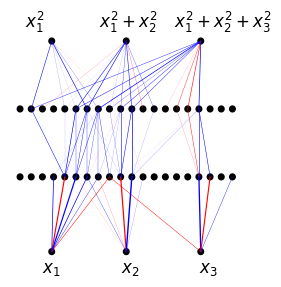

step = 2200 | total loss: 7.34e-03 | train loss: 7.49e-05 | test loss 1.12e-04 | reg: 7.26e+00 
step = 2400 | total loss: 6.57e-03 | train loss: 5.79e-05 | test loss 7.53e-05 | reg: 6.51e+00 
step = 2600 | total loss: 6.05e-03 | train loss: 5.39e-05 | test loss 7.12e-05 | reg: 5.99e+00 
step = 2800 | total loss: 5.65e-03 | train loss: 5.28e-05 | test loss 7.01e-05 | reg: 5.60e+00 
step = 3000 | total loss: 5.33e-03 | train loss: 5.12e-05 | test loss 7.10e-05 | reg: 5.27e+00 


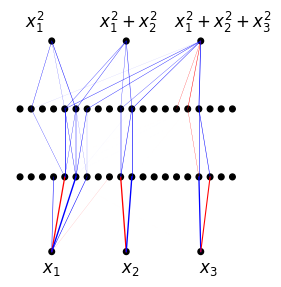

step = 3200 | total loss: 5.08e-03 | train loss: 5.05e-05 | test loss 6.97e-05 | reg: 5.03e+00 
step = 3400 | total loss: 4.89e-03 | train loss: 5.04e-05 | test loss 7.27e-05 | reg: 4.84e+00 
step = 3600 | total loss: 4.73e-03 | train loss: 5.25e-05 | test loss 7.37e-05 | reg: 4.68e+00 
step = 3800 | total loss: 4.47e-03 | train loss: 5.62e-05 | test loss 7.83e-05 | reg: 4.41e+00 
step = 4000 | total loss: 4.25e-03 | train loss: 5.98e-05 | test loss 8.42e-05 | reg: 4.19e+00 


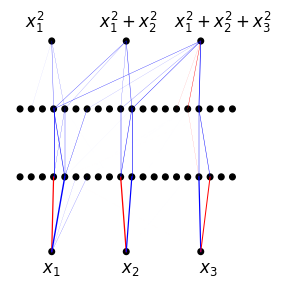

step = 4200 | total loss: 4.00e-03 | train loss: 6.24e-05 | test loss 9.12e-05 | reg: 3.94e+00 
step = 4400 | total loss: 3.77e-03 | train loss: 6.44e-05 | test loss 8.53e-05 | reg: 3.70e+00 
step = 4600 | total loss: 3.66e-03 | train loss: 6.17e-05 | test loss 8.07e-05 | reg: 3.60e+00 
step = 4800 | total loss: 3.61e-03 | train loss: 5.85e-05 | test loss 7.56e-05 | reg: 3.55e+00 
step = 5000 | total loss: 3.51e-02 | train loss: 5.87e-05 | test loss 7.44e-05 | reg: 3.50e+00 


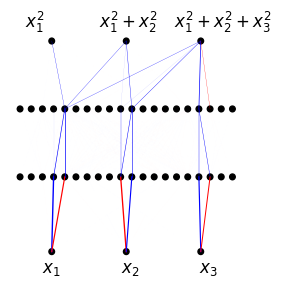

step = 5200 | total loss: 3.37e-02 | train loss: 3.19e-04 | test loss 3.12e-04 | reg: 3.34e+00 
step = 5400 | total loss: 3.34e-02 | train loss: 3.45e-04 | test loss 3.56e-04 | reg: 3.30e+00 
step = 5600 | total loss: 3.31e-02 | train loss: 3.31e-04 | test loss 3.32e-04 | reg: 3.28e+00 
step = 5800 | total loss: 3.29e-02 | train loss: 3.35e-04 | test loss 3.45e-04 | reg: 3.26e+00 
step = 6000 | total loss: 3.28e-02 | train loss: 3.46e-04 | test loss 3.59e-04 | reg: 3.25e+00 


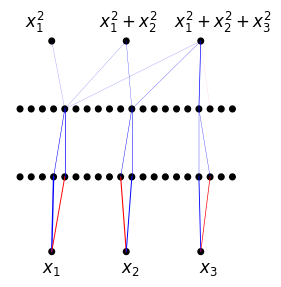

step = 6200 | total loss: 3.27e-02 | train loss: 3.64e-04 | test loss 3.83e-04 | reg: 3.24e+00 
step = 6400 | total loss: 3.26e-02 | train loss: 3.66e-04 | test loss 3.98e-04 | reg: 3.23e+00 
step = 6600 | total loss: 3.26e-02 | train loss: 3.83e-04 | test loss 3.87e-04 | reg: 3.22e+00 
step = 6800 | total loss: 3.25e-02 | train loss: 3.88e-04 | test loss 4.03e-04 | reg: 3.21e+00 
step = 7000 | total loss: 3.25e-02 | train loss: 3.98e-04 | test loss 4.23e-04 | reg: 3.21e+00 


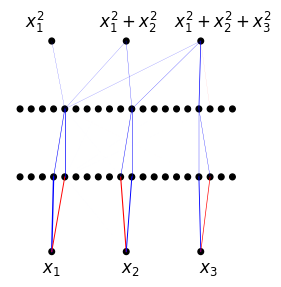

step = 7200 | total loss: 3.24e-02 | train loss: 4.05e-04 | test loss 4.31e-04 | reg: 3.20e+00 
step = 7400 | total loss: 3.24e-02 | train loss: 3.98e-04 | test loss 4.11e-04 | reg: 3.20e+00 
step = 7600 | total loss: 3.23e-02 | train loss: 4.20e-04 | test loss 4.52e-04 | reg: 3.19e+00 
step = 7800 | total loss: 3.23e-02 | train loss: 4.21e-04 | test loss 4.55e-04 | reg: 3.19e+00 
step = 8000 | total loss: 3.23e-02 | train loss: 4.22e-04 | test loss 4.53e-04 | reg: 3.18e+00 


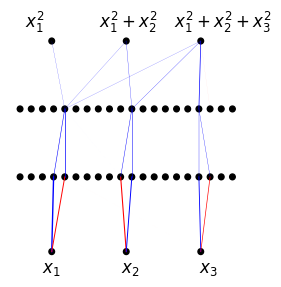

step = 8200 | total loss: 3.22e-02 | train loss: 4.36e-04 | test loss 4.74e-04 | reg: 3.18e+00 
step = 8400 | total loss: 3.22e-02 | train loss: 4.31e-04 | test loss 4.67e-04 | reg: 3.17e+00 
step = 8600 | total loss: 3.21e-02 | train loss: 4.35e-04 | test loss 4.79e-04 | reg: 3.17e+00 
step = 8800 | total loss: 3.21e-02 | train loss: 4.48e-04 | test loss 4.83e-04 | reg: 3.16e+00 
step = 9000 | total loss: 3.21e-02 | train loss: 4.47e-04 | test loss 4.89e-04 | reg: 3.16e+00 


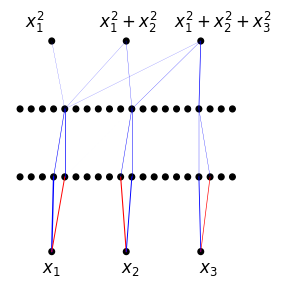

step = 9200 | total loss: 3.21e-02 | train loss: 4.58e-04 | test loss 5.11e-04 | reg: 3.16e+00 
step = 9400 | total loss: 3.20e-02 | train loss: 4.62e-04 | test loss 5.02e-04 | reg: 3.16e+00 
step = 9600 | total loss: 3.20e-02 | train loss: 4.75e-04 | test loss 5.17e-04 | reg: 3.16e+00 
step = 9800 | total loss: 3.20e-02 | train loss: 4.70e-04 | test loss 5.12e-04 | reg: 3.15e+00 
step = 10000 | total loss: 3.20e-02 | train loss: 4.86e-04 | test loss 5.37e-04 | reg: 3.15e+00 


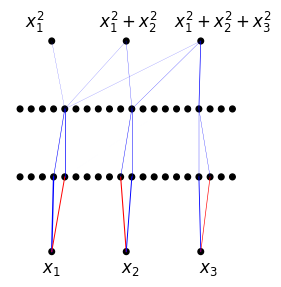

step = 10200 | total loss: 3.20e-02 | train loss: 4.86e-04 | test loss 5.30e-04 | reg: 3.15e+00 
step = 10400 | total loss: 3.20e-02 | train loss: 4.98e-04 | test loss 5.45e-04 | reg: 3.15e+00 
step = 10600 | total loss: 3.20e-02 | train loss: 4.94e-04 | test loss 5.28e-04 | reg: 3.15e+00 
step = 10800 | total loss: 3.20e-02 | train loss: 4.95e-04 | test loss 5.45e-04 | reg: 3.15e+00 
step = 11000 | total loss: 3.20e-02 | train loss: 5.14e-04 | test loss 5.65e-04 | reg: 3.15e+00 


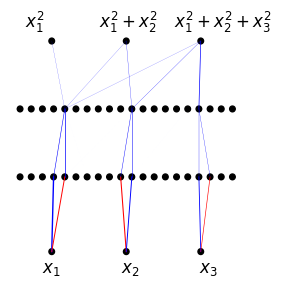

step = 11200 | total loss: 3.20e-02 | train loss: 5.11e-04 | test loss 5.57e-04 | reg: 3.14e+00 
step = 11400 | total loss: 3.19e-02 | train loss: 5.14e-04 | test loss 5.68e-04 | reg: 3.14e+00 
step = 11600 | total loss: 3.19e-02 | train loss: 5.05e-04 | test loss 5.51e-04 | reg: 3.14e+00 
step = 11800 | total loss: 3.19e-02 | train loss: 5.20e-04 | test loss 5.83e-04 | reg: 3.14e+00 
step = 12000 | total loss: 3.19e-02 | train loss: 5.28e-04 | test loss 5.74e-04 | reg: 3.14e+00 


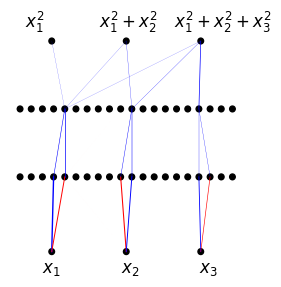

step = 12200 | total loss: 3.19e-02 | train loss: 5.21e-04 | test loss 5.88e-04 | reg: 3.14e+00 
step = 12400 | total loss: 3.19e-02 | train loss: 5.26e-04 | test loss 5.75e-04 | reg: 3.14e+00 
step = 12600 | total loss: 3.19e-02 | train loss: 5.29e-04 | test loss 5.77e-04 | reg: 3.14e+00 
step = 12800 | total loss: 3.19e-02 | train loss: 5.37e-04 | test loss 5.91e-04 | reg: 3.14e+00 
step = 13000 | total loss: 3.19e-02 | train loss: 5.30e-04 | test loss 5.73e-04 | reg: 3.13e+00 


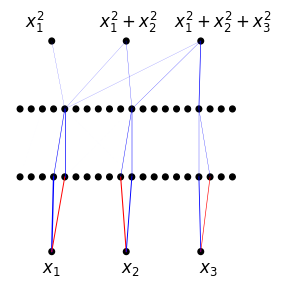

step = 13200 | total loss: 3.19e-02 | train loss: 5.33e-04 | test loss 6.09e-04 | reg: 3.14e+00 
step = 13400 | total loss: 3.19e-02 | train loss: 5.34e-04 | test loss 5.85e-04 | reg: 3.14e+00 
step = 13600 | total loss: 3.19e-02 | train loss: 5.31e-04 | test loss 5.86e-04 | reg: 3.14e+00 
step = 13800 | total loss: 3.19e-02 | train loss: 5.33e-04 | test loss 5.81e-04 | reg: 3.14e+00 
step = 14000 | total loss: 3.19e-02 | train loss: 5.35e-04 | test loss 5.97e-04 | reg: 3.14e+00 


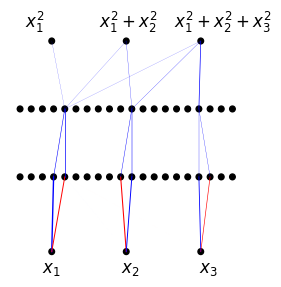

step = 14200 | total loss: 3.19e-02 | train loss: 5.30e-04 | test loss 5.90e-04 | reg: 3.13e+00 
step = 14400 | total loss: 3.19e-02 | train loss: 5.43e-04 | test loss 6.04e-04 | reg: 3.13e+00 
step = 14600 | total loss: 3.19e-02 | train loss: 5.49e-04 | test loss 5.97e-04 | reg: 3.13e+00 
step = 14800 | total loss: 3.19e-02 | train loss: 5.35e-04 | test loss 5.82e-04 | reg: 3.13e+00 
step = 15000 | total loss: 5.52e-03 | train loss: 5.40e-04 | test loss 6.00e-04 | reg: 4.98e+00 


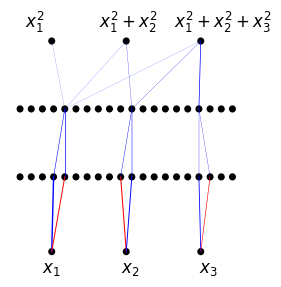

step = 15200 | total loss: 4.20e-03 | train loss: 1.57e-04 | test loss 1.96e-04 | reg: 4.05e+00 
step = 15400 | total loss: 4.04e-03 | train loss: 1.08e-04 | test loss 1.38e-04 | reg: 3.93e+00 
step = 15600 | total loss: 3.92e-03 | train loss: 8.66e-05 | test loss 1.12e-04 | reg: 3.83e+00 
step = 15800 | total loss: 3.82e-03 | train loss: 7.55e-05 | test loss 9.65e-05 | reg: 3.74e+00 
step = 16000 | total loss: 3.77e-03 | train loss: 6.86e-05 | test loss 8.69e-05 | reg: 3.70e+00 


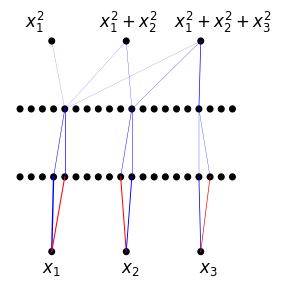

step = 16200 | total loss: 3.74e-03 | train loss: 6.61e-05 | test loss 8.24e-05 | reg: 3.67e+00 
step = 16400 | total loss: 3.71e-03 | train loss: 6.61e-05 | test loss 8.02e-05 | reg: 3.64e+00 
step = 16600 | total loss: 3.68e-03 | train loss: 6.77e-05 | test loss 8.16e-05 | reg: 3.62e+00 
step = 16800 | total loss: 3.66e-03 | train loss: 6.96e-05 | test loss 8.34e-05 | reg: 3.59e+00 
step = 17000 | total loss: 3.64e-03 | train loss: 7.12e-05 | test loss 8.52e-05 | reg: 3.57e+00 


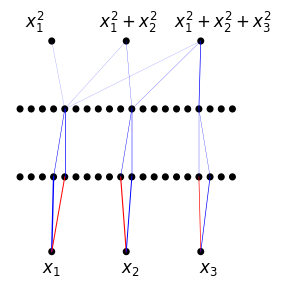

step = 17200 | total loss: 3.62e-03 | train loss: 7.29e-05 | test loss 8.51e-05 | reg: 3.55e+00 
step = 17400 | total loss: 3.61e-03 | train loss: 7.35e-05 | test loss 8.77e-05 | reg: 3.53e+00 
step = 17600 | total loss: 3.59e-03 | train loss: 7.36e-05 | test loss 8.74e-05 | reg: 3.52e+00 
step = 17800 | total loss: 3.58e-03 | train loss: 7.33e-05 | test loss 8.73e-05 | reg: 3.50e+00 
step = 18000 | total loss: 3.56e-03 | train loss: 7.27e-05 | test loss 8.85e-05 | reg: 3.49e+00 


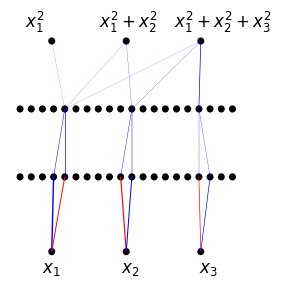

step = 18200 | total loss: 3.55e-03 | train loss: 7.17e-05 | test loss 8.54e-05 | reg: 3.48e+00 
step = 18400 | total loss: 3.54e-03 | train loss: 7.17e-05 | test loss 8.74e-05 | reg: 3.47e+00 
step = 18600 | total loss: 3.53e-03 | train loss: 7.07e-05 | test loss 8.61e-05 | reg: 3.46e+00 
step = 18800 | total loss: 3.52e-03 | train loss: 7.02e-05 | test loss 8.41e-05 | reg: 3.45e+00 
step = 19000 | total loss: 3.51e-03 | train loss: 6.99e-05 | test loss 8.43e-05 | reg: 3.44e+00 


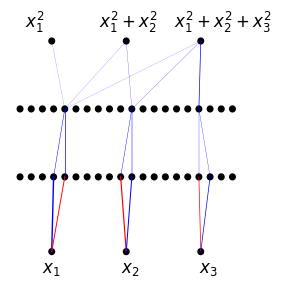

step = 19200 | total loss: 3.50e-03 | train loss: 6.92e-05 | test loss 8.53e-05 | reg: 3.43e+00 
step = 19400 | total loss: 3.49e-03 | train loss: 6.89e-05 | test loss 8.28e-05 | reg: 3.42e+00 
step = 19600 | total loss: 3.48e-03 | train loss: 6.91e-05 | test loss 8.38e-05 | reg: 3.41e+00 
step = 19800 | total loss: 3.48e-03 | train loss: 6.93e-05 | test loss 8.27e-05 | reg: 3.41e+00 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# create dataset

seed = 4
np.random.seed(seed)
torch.manual_seed(seed)


def f(data):
    x1 = data[:,[0]]
    x2 = data[:,[1]]
    x3 = data[:,[2]]    
    out = np.transpose(np.array([x1**2, x1**2+x2**2, x1**2+x2**2+x3**2]))
    return out


d_in = 3
d_out = 3

inputs = np.random.rand(100,d_in)*2-1
labels = f(inputs)

inputs = torch.tensor(inputs, dtype=torch.float, requires_grad=True)
labels = torch.tensor(labels, dtype=torch.float, requires_grad=True)

inputs_test = np.random.rand(100,d_in)*2-1
labels_test = f(inputs_test)

inputs_test = torch.tensor(inputs_test, dtype=torch.float, requires_grad=True)
labels_test = torch.tensor(labels_test, dtype=torch.float, requires_grad=True)


width = 20
depth = 3
shp = [d_in, 20, 20, d_out]


model = BioMLP(shp=shp)

# train_type = 1; no L1
# train_type = 2; L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
train_type = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
log = 200
lamb = 0 if train_type==1 else 0.001
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.
plot_log = 1000
steps = 20000
 
for step in range(steps):
    
    if step == int(steps/4):
        lamb *= 10
    
    if step == int(3*steps/4):
        lamb *= 0.1
    
    optimizer.zero_grad()
    pred  = model(inputs)
    loss = torch.mean((pred-labels)**2)
    pred_test  = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    
    # do not penalize bias at first (this makes the weight graph look better)
    if step < int(3*steps/4):
        reg = model.get_cc(bias_penalize=False, weight_factor=weight_factor)
    else:
        reg = model.get_cc(bias_penalize=True, weight_factor=weight_factor)
    #reg = model.get_cc(bias_penalize=True)
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        model.relocate()

    if step % plot_log == 0:
        model.plot()
        formulas = [r"$x_1^2$", r"$x_1^2+x_2^2$", r"$x_1^2+x_2^2+x_3^2$"]
        fontsize = 12
        for j in range(shp[0]):
            plt.text(1/(2*shp[1])+7*j/shp[1]+0.1, -0.04, "$x_{}$".format(model.in_perm[j].long()+1), fontsize=fontsize)

        for j in range(shp[-1]):
            plt.text(1/(2*shp[0])+j/shp[0]-0.12, 0.1*(len(shp)-1)+0.02, formulas[model.out_perm[j].long()], fontsize=fontsize)

        #plt.savefig("./video_figs/sf_fs/{0:05d}.png".format(step))
        plt.show()
    

Text(0.5, 1.0, 'feature sharing\n test MSE = 8.5e-5')

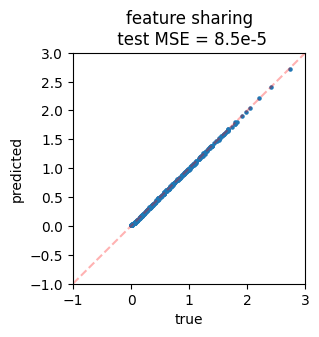

In [ ]:
plt.figure(figsize=(3,3))
plt.plot([-6,6],[-6,6],ls="--",color="red", alpha=0.3)
plt.scatter(labels_test.detach().numpy(), pred_test.detach().numpy(), s=5)
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("feature sharing\n test MSE = 8.5e-5")
#plt.savefig("./fig/feature_sharing_compare.png", bbox_inches="tight")

## The independence example. NN takes in $(x_1,x_2,x_3,x_4)$ and aims to predict $\sqrt{(x_1-x_2)^2+(x_3-x_4)}$.

step = 0 | total loss: 1.78e+00 | train loss: 1.72e+00 | test loss 1.91e+00 | reg: 6.72e+01 


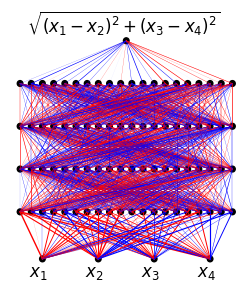

step = 200 | total loss: 1.47e-01 | train loss: 9.66e-02 | test loss 1.66e-01 | reg: 5.05e+01 
step = 400 | total loss: 5.21e-02 | train loss: 1.99e-02 | test loss 2.76e-02 | reg: 3.23e+01 
step = 600 | total loss: 3.20e-02 | train loss: 1.05e-02 | test loss 1.28e-02 | reg: 2.15e+01 
step = 800 | total loss: 2.14e-02 | train loss: 5.29e-03 | test loss 5.54e-03 | reg: 1.61e+01 
step = 1000 | total loss: 1.56e-02 | train loss: 2.64e-03 | test loss 2.12e-03 | reg: 1.30e+01 


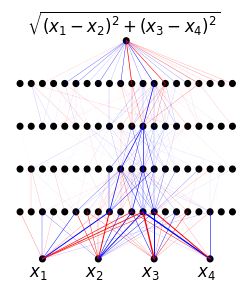

step = 1200 | total loss: 1.27e-02 | train loss: 1.67e-03 | test loss 1.17e-03 | reg: 1.10e+01 
step = 1400 | total loss: 1.07e-02 | train loss: 1.20e-03 | test loss 9.39e-04 | reg: 9.55e+00 
step = 1600 | total loss: 9.45e-03 | train loss: 9.75e-04 | test loss 1.01e-03 | reg: 8.48e+00 
step = 1800 | total loss: 8.56e-03 | train loss: 8.25e-04 | test loss 1.19e-03 | reg: 7.73e+00 
step = 2000 | total loss: 7.89e-03 | train loss: 7.49e-04 | test loss 1.37e-03 | reg: 7.14e+00 


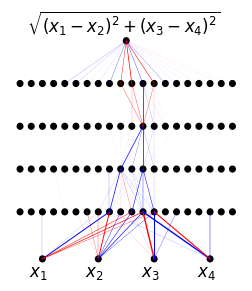

step = 2200 | total loss: 7.36e-03 | train loss: 7.20e-04 | test loss 1.50e-03 | reg: 6.65e+00 
step = 2400 | total loss: 6.91e-03 | train loss: 6.96e-04 | test loss 1.61e-03 | reg: 6.22e+00 
step = 2600 | total loss: 6.49e-03 | train loss: 6.89e-04 | test loss 1.62e-03 | reg: 5.80e+00 
step = 2800 | total loss: 6.15e-03 | train loss: 6.79e-04 | test loss 1.45e-03 | reg: 5.47e+00 
step = 3000 | total loss: 5.87e-03 | train loss: 6.68e-04 | test loss 1.29e-03 | reg: 5.20e+00 


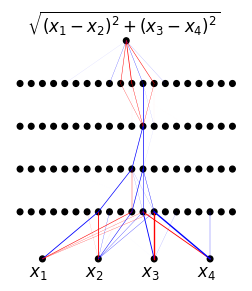

step = 3200 | total loss: 5.63e-03 | train loss: 6.81e-04 | test loss 1.23e-03 | reg: 4.95e+00 
step = 3400 | total loss: 5.41e-03 | train loss: 6.80e-04 | test loss 1.18e-03 | reg: 4.73e+00 
step = 3600 | total loss: 5.20e-03 | train loss: 6.43e-04 | test loss 1.11e-03 | reg: 4.56e+00 
step = 3800 | total loss: 5.05e-03 | train loss: 5.71e-04 | test loss 9.91e-04 | reg: 4.48e+00 
step = 4000 | total loss: 4.96e-03 | train loss: 5.11e-04 | test loss 8.64e-04 | reg: 4.44e+00 


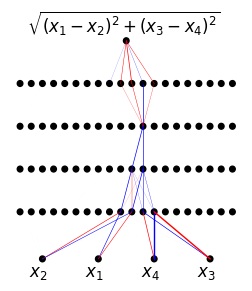

step = 4200 | total loss: 4.89e-03 | train loss: 4.68e-04 | test loss 7.99e-04 | reg: 4.42e+00 
step = 4400 | total loss: 4.83e-03 | train loss: 4.33e-04 | test loss 7.33e-04 | reg: 4.40e+00 
step = 4600 | total loss: 4.77e-03 | train loss: 4.04e-04 | test loss 6.81e-04 | reg: 4.37e+00 
step = 4800 | total loss: 4.71e-03 | train loss: 3.80e-04 | test loss 6.65e-04 | reg: 4.33e+00 
step = 5000 | total loss: 1.32e-02 | train loss: 3.63e-04 | test loss 6.44e-04 | reg: 4.29e+00 


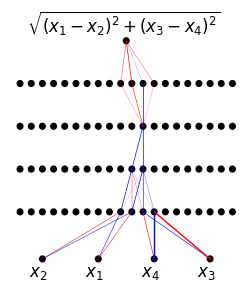

step = 5200 | total loss: 1.28e-02 | train loss: 7.84e-04 | test loss 7.81e-04 | reg: 4.01e+00 
step = 5400 | total loss: 1.24e-02 | train loss: 8.31e-04 | test loss 9.09e-04 | reg: 3.84e+00 
step = 5600 | total loss: 1.19e-02 | train loss: 9.01e-04 | test loss 1.04e-03 | reg: 3.67e+00 
step = 5800 | total loss: 1.17e-02 | train loss: 9.54e-04 | test loss 1.14e-03 | reg: 3.57e+00 
step = 6000 | total loss: 1.15e-02 | train loss: 1.00e-03 | test loss 1.20e-03 | reg: 3.49e+00 


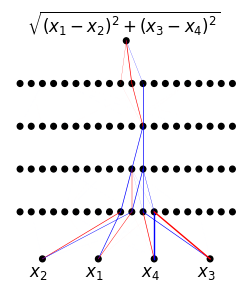

step = 6200 | total loss: 1.13e-02 | train loss: 1.03e-03 | test loss 1.22e-03 | reg: 3.43e+00 
step = 6400 | total loss: 1.13e-02 | train loss: 1.05e-03 | test loss 1.27e-03 | reg: 3.41e+00 
step = 6600 | total loss: 1.12e-02 | train loss: 1.05e-03 | test loss 1.25e-03 | reg: 3.38e+00 
step = 6800 | total loss: 1.12e-02 | train loss: 1.08e-03 | test loss 1.25e-03 | reg: 3.36e+00 
step = 7000 | total loss: 1.11e-02 | train loss: 1.06e-03 | test loss 1.27e-03 | reg: 3.34e+00 


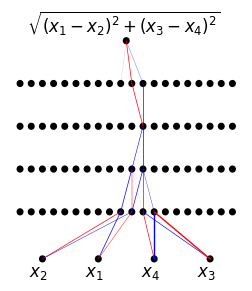

step = 7200 | total loss: 1.10e-02 | train loss: 1.07e-03 | test loss 1.28e-03 | reg: 3.32e+00 
step = 7400 | total loss: 1.10e-02 | train loss: 1.07e-03 | test loss 1.29e-03 | reg: 3.31e+00 
step = 7600 | total loss: 1.09e-02 | train loss: 1.07e-03 | test loss 1.32e-03 | reg: 3.29e+00 
step = 7800 | total loss: 1.09e-02 | train loss: 1.08e-03 | test loss 1.31e-03 | reg: 3.28e+00 
step = 8000 | total loss: 1.09e-02 | train loss: 1.08e-03 | test loss 1.34e-03 | reg: 3.27e+00 


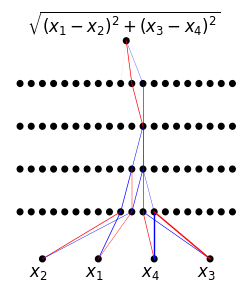

step = 8200 | total loss: 1.09e-02 | train loss: 1.09e-03 | test loss 1.32e-03 | reg: 3.26e+00 
step = 8400 | total loss: 1.08e-02 | train loss: 1.10e-03 | test loss 1.39e-03 | reg: 3.24e+00 
step = 8600 | total loss: 1.08e-02 | train loss: 1.08e-03 | test loss 1.32e-03 | reg: 3.24e+00 
step = 8800 | total loss: 1.08e-02 | train loss: 1.08e-03 | test loss 1.32e-03 | reg: 3.23e+00 
step = 9000 | total loss: 1.07e-02 | train loss: 1.08e-03 | test loss 1.31e-03 | reg: 3.21e+00 


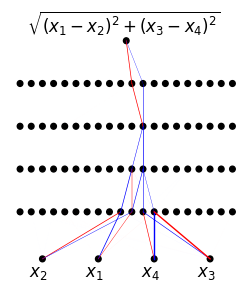

step = 9200 | total loss: 1.07e-02 | train loss: 1.07e-03 | test loss 1.31e-03 | reg: 3.21e+00 
step = 9400 | total loss: 1.07e-02 | train loss: 1.06e-03 | test loss 1.32e-03 | reg: 3.21e+00 
step = 9600 | total loss: 1.07e-02 | train loss: 1.06e-03 | test loss 1.32e-03 | reg: 3.21e+00 
step = 9800 | total loss: 1.07e-02 | train loss: 1.06e-03 | test loss 1.28e-03 | reg: 3.20e+00 
step = 10000 | total loss: 1.06e-02 | train loss: 1.06e-03 | test loss 1.28e-03 | reg: 3.20e+00 


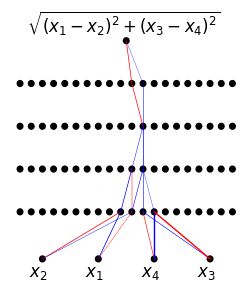

step = 10200 | total loss: 1.07e-02 | train loss: 1.08e-03 | test loss 1.27e-03 | reg: 3.19e+00 
step = 10400 | total loss: 1.06e-02 | train loss: 1.06e-03 | test loss 1.30e-03 | reg: 3.19e+00 
step = 10600 | total loss: 1.06e-02 | train loss: 1.06e-03 | test loss 1.30e-03 | reg: 3.18e+00 
step = 10800 | total loss: 1.06e-02 | train loss: 1.05e-03 | test loss 1.27e-03 | reg: 3.18e+00 
step = 11000 | total loss: 1.06e-02 | train loss: 1.05e-03 | test loss 1.28e-03 | reg: 3.18e+00 


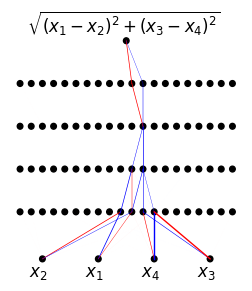

step = 11200 | total loss: 1.06e-02 | train loss: 1.05e-03 | test loss 1.28e-03 | reg: 3.17e+00 
step = 11400 | total loss: 1.06e-02 | train loss: 1.05e-03 | test loss 1.29e-03 | reg: 3.17e+00 
step = 11600 | total loss: 1.06e-02 | train loss: 1.06e-03 | test loss 1.31e-03 | reg: 3.17e+00 
step = 11800 | total loss: 1.05e-02 | train loss: 1.04e-03 | test loss 1.27e-03 | reg: 3.16e+00 
step = 12000 | total loss: 1.05e-02 | train loss: 1.05e-03 | test loss 1.25e-03 | reg: 3.16e+00 


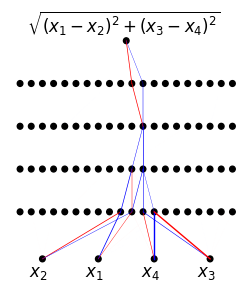

step = 12200 | total loss: 1.05e-02 | train loss: 1.04e-03 | test loss 1.28e-03 | reg: 3.16e+00 
step = 12400 | total loss: 1.05e-02 | train loss: 1.05e-03 | test loss 1.23e-03 | reg: 3.15e+00 
step = 12600 | total loss: 1.05e-02 | train loss: 1.04e-03 | test loss 1.24e-03 | reg: 3.15e+00 
step = 12800 | total loss: 1.05e-02 | train loss: 1.09e-03 | test loss 1.34e-03 | reg: 3.15e+00 
step = 13000 | total loss: 1.05e-02 | train loss: 1.04e-03 | test loss 1.24e-03 | reg: 3.15e+00 


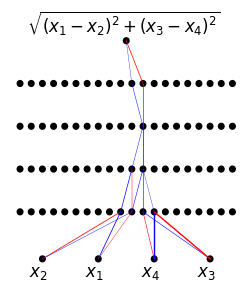

step = 13200 | total loss: 1.05e-02 | train loss: 1.02e-03 | test loss 1.24e-03 | reg: 3.15e+00 
step = 13400 | total loss: 1.05e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.14e+00 
step = 13600 | total loss: 1.05e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.14e+00 
step = 13800 | total loss: 1.05e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.14e+00 
step = 14000 | total loss: 1.04e-02 | train loss: 1.03e-03 | test loss 1.23e-03 | reg: 3.14e+00 


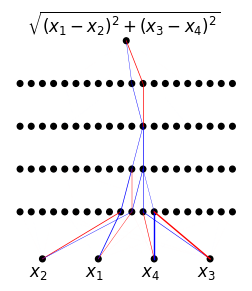

step = 14200 | total loss: 1.04e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.14e+00 
step = 14400 | total loss: 1.04e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.13e+00 
step = 14600 | total loss: 1.04e-02 | train loss: 1.03e-03 | test loss 1.24e-03 | reg: 3.13e+00 
step = 14800 | total loss: 1.04e-02 | train loss: 1.04e-03 | test loss 1.28e-03 | reg: 3.12e+00 
step = 15000 | total loss: 1.47e-02 | train loss: 1.03e-03 | test loss 1.23e-03 | reg: 4.55e+00 


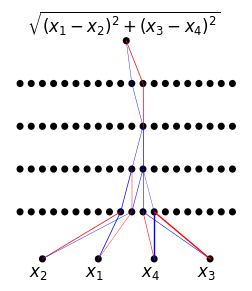

step = 15200 | total loss: 1.29e-02 | train loss: 1.04e-03 | test loss 1.26e-03 | reg: 3.95e+00 
step = 15400 | total loss: 1.28e-02 | train loss: 1.05e-03 | test loss 1.27e-03 | reg: 3.93e+00 
step = 15600 | total loss: 1.28e-02 | train loss: 1.05e-03 | test loss 1.25e-03 | reg: 3.92e+00 
step = 15800 | total loss: 1.28e-02 | train loss: 1.05e-03 | test loss 1.27e-03 | reg: 3.90e+00 
step = 16000 | total loss: 1.27e-02 | train loss: 1.06e-03 | test loss 1.28e-03 | reg: 3.88e+00 


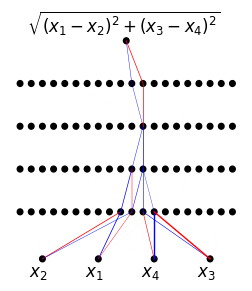

step = 16200 | total loss: 1.27e-02 | train loss: 1.07e-03 | test loss 1.29e-03 | reg: 3.87e+00 
step = 16400 | total loss: 1.27e-02 | train loss: 1.08e-03 | test loss 1.32e-03 | reg: 3.86e+00 
step = 16600 | total loss: 1.26e-02 | train loss: 1.08e-03 | test loss 1.32e-03 | reg: 3.84e+00 
step = 16800 | total loss: 1.26e-02 | train loss: 1.09e-03 | test loss 1.31e-03 | reg: 3.83e+00 
step = 17000 | total loss: 1.25e-02 | train loss: 1.10e-03 | test loss 1.32e-03 | reg: 3.81e+00 


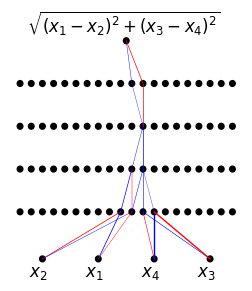

step = 17200 | total loss: 1.25e-02 | train loss: 1.11e-03 | test loss 1.36e-03 | reg: 3.81e+00 
step = 17400 | total loss: 1.25e-02 | train loss: 1.11e-03 | test loss 1.35e-03 | reg: 3.81e+00 
step = 17600 | total loss: 1.25e-02 | train loss: 1.11e-03 | test loss 1.36e-03 | reg: 3.80e+00 
step = 17800 | total loss: 1.25e-02 | train loss: 1.13e-03 | test loss 1.40e-03 | reg: 3.79e+00 
step = 18000 | total loss: 1.25e-02 | train loss: 1.12e-03 | test loss 1.38e-03 | reg: 3.78e+00 


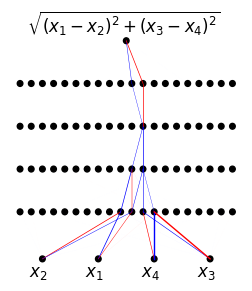

step = 18200 | total loss: 1.25e-02 | train loss: 1.12e-03 | test loss 1.38e-03 | reg: 3.78e+00 
step = 18400 | total loss: 1.24e-02 | train loss: 1.13e-03 | test loss 1.37e-03 | reg: 3.77e+00 
step = 18600 | total loss: 1.24e-02 | train loss: 1.14e-03 | test loss 1.38e-03 | reg: 3.76e+00 
step = 18800 | total loss: 1.24e-02 | train loss: 1.14e-03 | test loss 1.39e-03 | reg: 3.76e+00 
step = 19000 | total loss: 1.24e-02 | train loss: 1.15e-03 | test loss 1.42e-03 | reg: 3.75e+00 


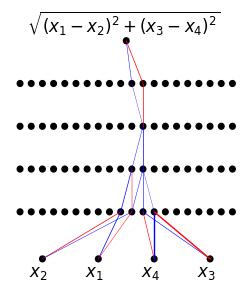

step = 19200 | total loss: 1.24e-02 | train loss: 1.16e-03 | test loss 1.39e-03 | reg: 3.75e+00 
step = 19400 | total loss: 1.24e-02 | train loss: 1.17e-03 | test loss 1.43e-03 | reg: 3.74e+00 
step = 19600 | total loss: 1.24e-02 | train loss: 1.17e-03 | test loss 1.43e-03 | reg: 3.74e+00 
step = 19800 | total loss: 1.24e-02 | train loss: 1.18e-03 | test loss 1.41e-03 | reg: 3.74e+00 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# create dataset

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)


def f(data):
    x1 = data[:,[0]]
    x2 = data[:,[1]]
    x3 = data[:,[2]]
    x4 = data[:,[3]]
    #out = np.transpose(np.array([(x1+x3)**3, x2**2+np.sin(np.pi*x4)]))
    #out = np.transpose(np.array([x1**2, x1**2+x2**2, x1**2+x2**2+x3**2]))
    out = np.transpose(np.array([np.sqrt((x1-x2)**2+(x3-x4)**2)]))
    return out


d_in = 4
d_out = 1

inputs = np.random.rand(100,d_in)*2-1
labels = f(inputs)

inputs = torch.tensor(inputs, dtype=torch.float, requires_grad=True)
labels = torch.tensor(labels, dtype=torch.float, requires_grad=True)

inputs_test = np.random.rand(100,d_in)*2-1
labels_test = f(inputs_test)

inputs_test = torch.tensor(inputs_test, dtype=torch.float, requires_grad=True)
labels_test = torch.tensor(labels_test, dtype=torch.float, requires_grad=True)


width = 20
depth = 5
shp = [d_in, 20, 20, 20, 20, d_out]


model = BioMLP(shp=shp)

# train_type = 1; no L1
# train_type = 2; L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
train_type = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
log = 200
lamb = 0 if train_type==1 else 0.001
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.
plot_log = 1000
steps = 20000
 
for step in range(steps):
    
    if step == int(steps/4):
        lamb *= 3
    
    if step == int(3*steps/4):
        lamb *= 1
    
    optimizer.zero_grad()
    pred  = model(inputs)
    loss = torch.mean((pred-labels)**2)
    pred_test  = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    
    # do not penalize bias at first (this makes the weight graph look better)
    if step < int(3*steps/4):
        reg = model.get_cc(bias_penalize=False, weight_factor=weight_factor)
    else:
        reg = model.get_cc(bias_penalize=True, weight_factor=weight_factor)
    #reg = model.get_cc(bias_penalize=True)
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), loss_test.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        model.relocate()

    if step % plot_log == 0:
        model.plot()
        formulas = [r"$\sqrt{(x_1-x_2)^2+(x_3-x_4)^2}$"]
        fontsize = 12
        for j in range(shp[0]):
            plt.text(1/(2*shp[1])+5*j/shp[1]+0.04, -0.05, "$x_{}$".format(model.in_perm[j].long()+1), fontsize=fontsize)

        for j in range(shp[-1]):
            plt.text(1/(2*shp[0])+j/shp[0]-0.07, 0.1*(len(shp)-1)+0.02, formulas[model.out_perm[j].long()], fontsize=fontsize)
    
        #plt.savefig("./video_figs/sf_comp/{0:05d}.png".format(step))
        plt.show()
    

Text(0.5, 1.0, 'compositionality\n test MSE = 1.3e-3')

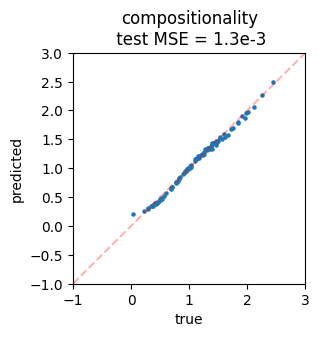

In [ ]:
plt.figure(figsize=(3,3))
plt.plot([-6,6],[-6,6],ls="--",color="red", alpha=0.3)
plt.scatter(labels_test.detach().numpy(), pred_test.detach().numpy(), s=5)
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("compositionality\n test MSE = 1.3e-3")
#plt.savefig("./fig/compositionality_compare.png", bbox_inches="tight")